# Masking and flattening a spectrum

Often in high resolution spectroscopy we wish to designate the *continuum*---regions in the spectrum devoid of spectral lines.  The continuum is conspicuous in hot stars, but becomes ill-defined in cool M-dwarfs.  In this tutorial we show how to define the continuum using `muler` and `specutils`.

In [1]:
from muler.hpf import HPFSpectrum
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [3]:
path = 'https://github.com/OttoStruve/muler_example_data/raw/main/HPF/01_A0V_standards/'
filename = 'Goldilocks_20210801T083618_v1.0_0036.spectra.fits'
raw_spectrum = HPFSpectrum(file = path+filename, order=6)

In [4]:
spectrum = raw_spectrum.sky_subtract(method='vector').remove_nans().deblaze().normalize()

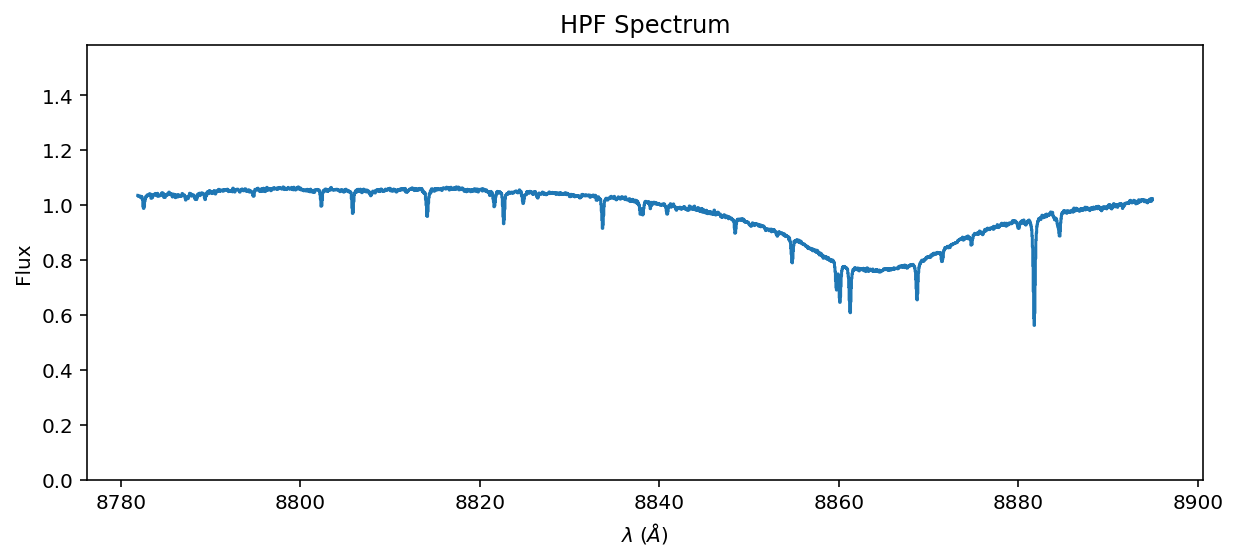

In [5]:
spectrum.plot(ylo=0);

Look at those conspicuous sharp spectral lines and the smooth dip near 10940 Angstroms.  Let's divide the spectrum by a tuned model.

In [6]:
from gollum.phoenix import PHOENIXSpectrum

In [7]:
native_template = PHOENIXSpectrum(teff=9600, logg=5.0, download=True).normalize()

In [8]:
doctored_template = native_template\
                        .rotationally_broaden(105.0)\
                        .rv_shift(-40.0)\
                        .resample(spectrum)\
                        .normalize()

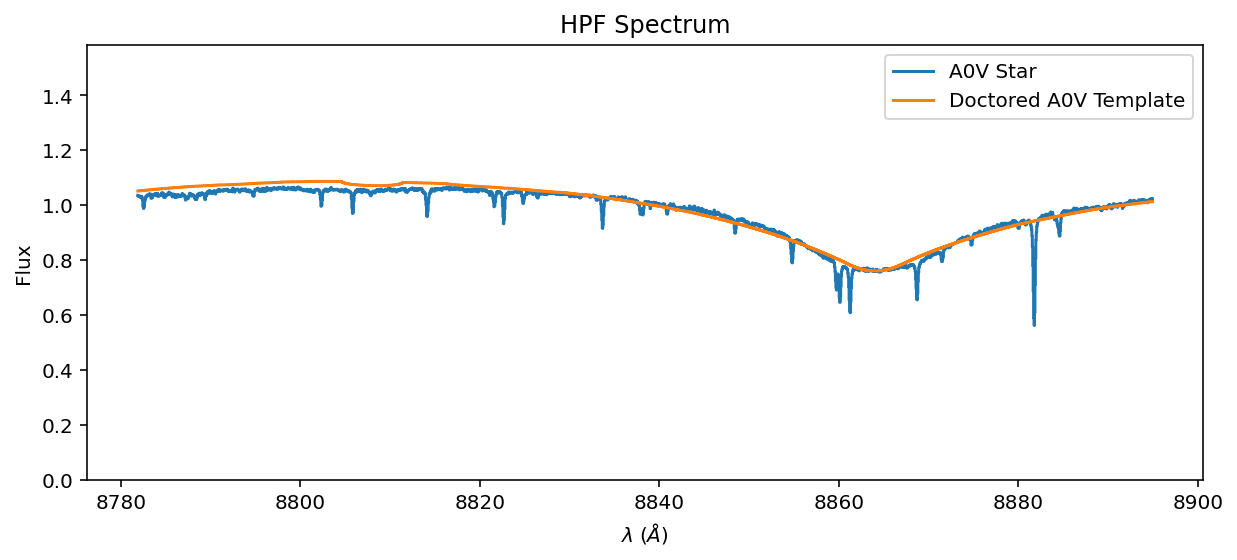

In [9]:
ax = spectrum.plot(ylo=0, label='A0V Star');
doctored_template.plot(ax=ax, label='Doctored A0V Template'); ax.legend();

In [10]:
telluric_response = spectrum / doctored_template

Normalize by the top 10th percentile, rather than the median...

In [11]:
spectrum_peak = np.percentile(telluric_response.flux, 65)

In [12]:
telluric_response = telluric_response.divide(spectrum_peak)

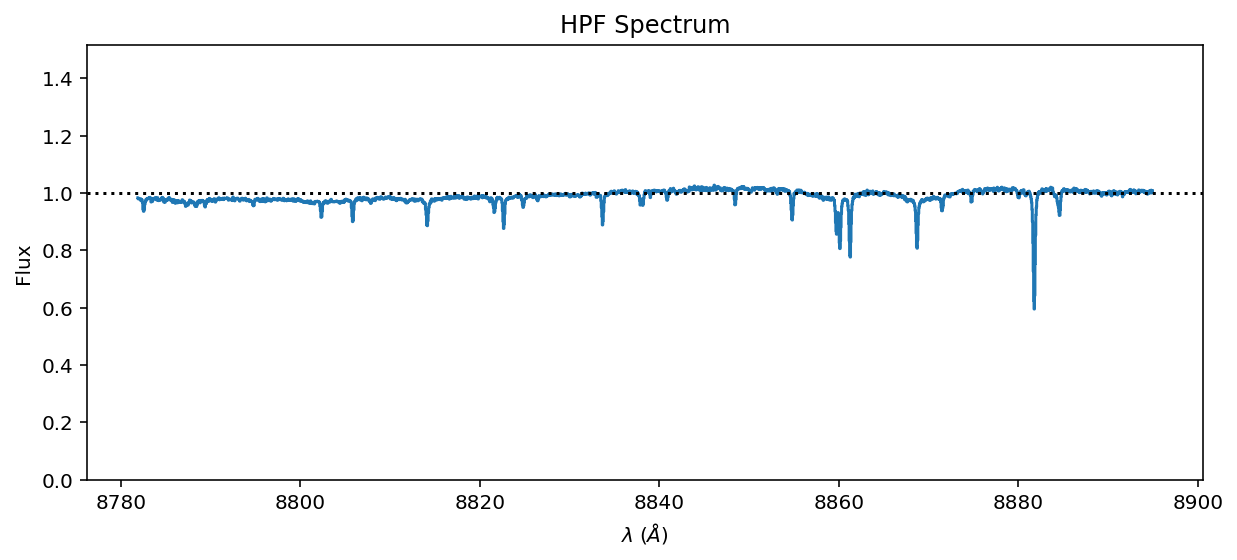

In [13]:
ax = telluric_response.plot(ylo=0);
ax.axhline(1.0, color='k', linestyle='dotted');

The continuum should all hover near $1.0$.  You can see that the spectrum has a slight downward curvature to it, with the blue-most values about $5\%$ lower than $1.0$, and some red-end values exceeding $1.0$ by 2 percentage points.  

Let's mask all the lines, fit a smooth function to the continuum, and then flatten by that function, evaluated at all wavelength points.


## Masking the lines and fitting the continuum

In [14]:
import astropy.units as u
from specutils import SpectralRegion
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_derivative, fit_continuum

In [15]:
continuum_subtracted = telluric_response-1.0

Here we find all the absorption lines above some threshold.

In [16]:
lines = find_lines_derivative(continuum_subtracted, flux_threshold=0.05)
lines = lines[lines['line_type'] == 'absorption']
len(lines)

16

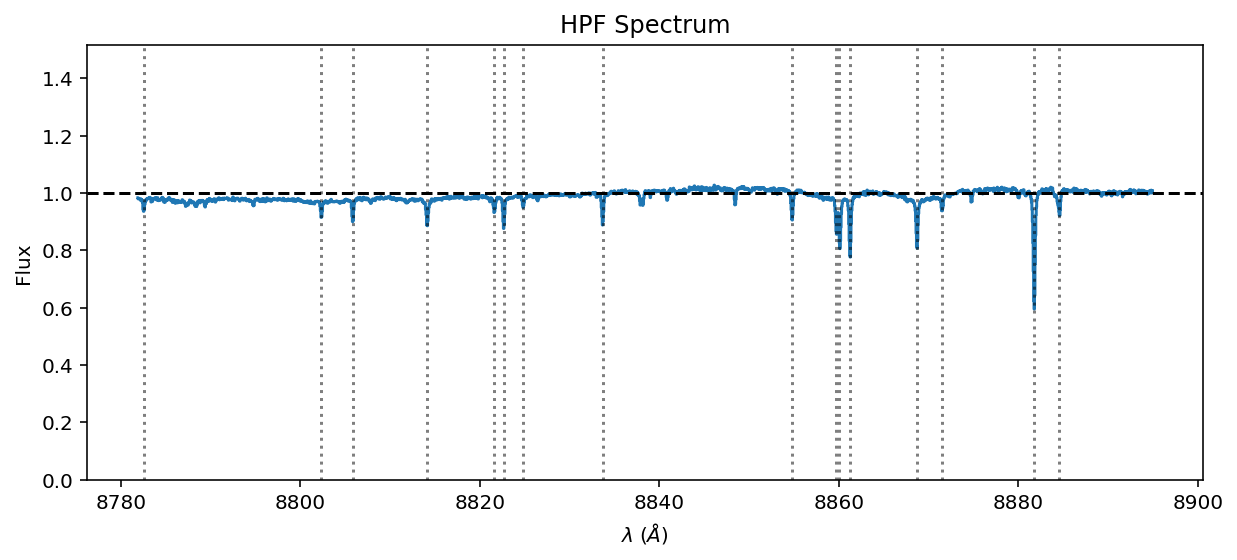

In [17]:
ax = telluric_response.plot(ylo=0);
ax.axhline(1.0, color='k', linestyle='dashed');

for line in lines:
    ax.axvline(line['line_center'].value, linestyle='dotted', color='k', alpha=0.5)

Neat, we see that we have found the most conspicuous lines.  Let's mask these lines with a $\pm1\;$A width. 

In [18]:
line_regions = SpectralRegion.from_line_list(lines, width=2.0*u.Angstrom)

Fit the continuum while excluding the spectral lines.

In [19]:
%%capture
continuum_model = fit_continuum(telluric_response, exclude_regions=line_regions)

In [20]:
continuum_fit = continuum_model(telluric_response.wavelength)
continuum_spectrum = HPFSpectrum(flux=continuum_fit, 
                                 spectral_axis = telluric_response.wavelength)

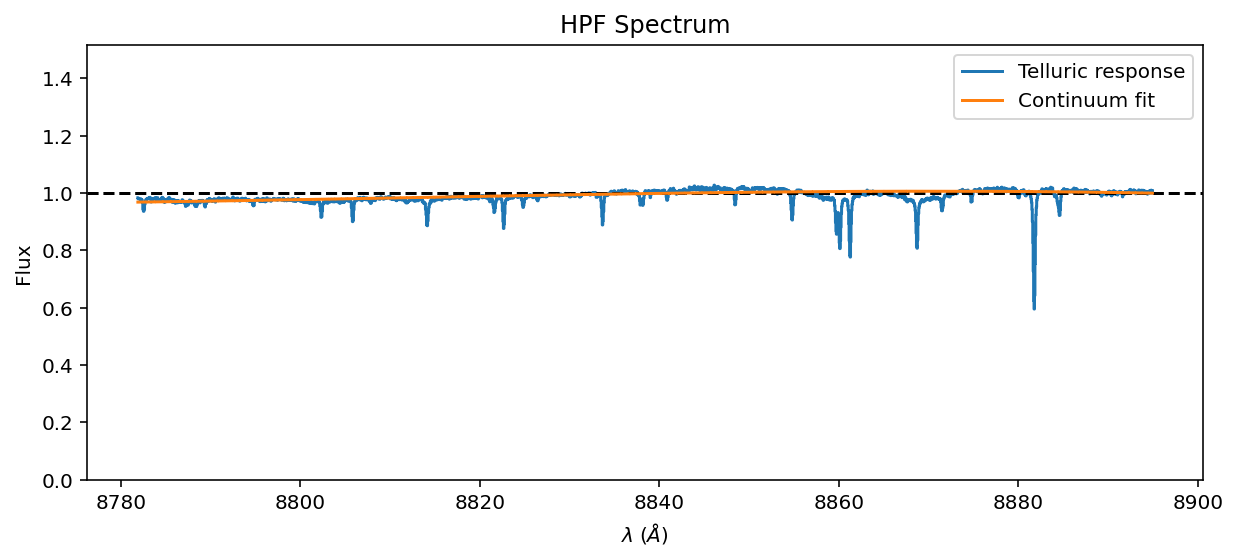

In [21]:
ax=telluric_response.plot(ylo=0, label='Telluric response')
ax.axhline(1.0, color='k', linestyle='dashed');
continuum_spectrum.plot(ax=ax, label='Continuum fit');
ax.legend();

Nice!  That looks OK.  You can see that we are fitting to weak telluric lines at 10910 A, which pulls down the fit from 10890.  So it's not perfect.

In [22]:
flattened_telluric = telluric_response/continuum_spectrum

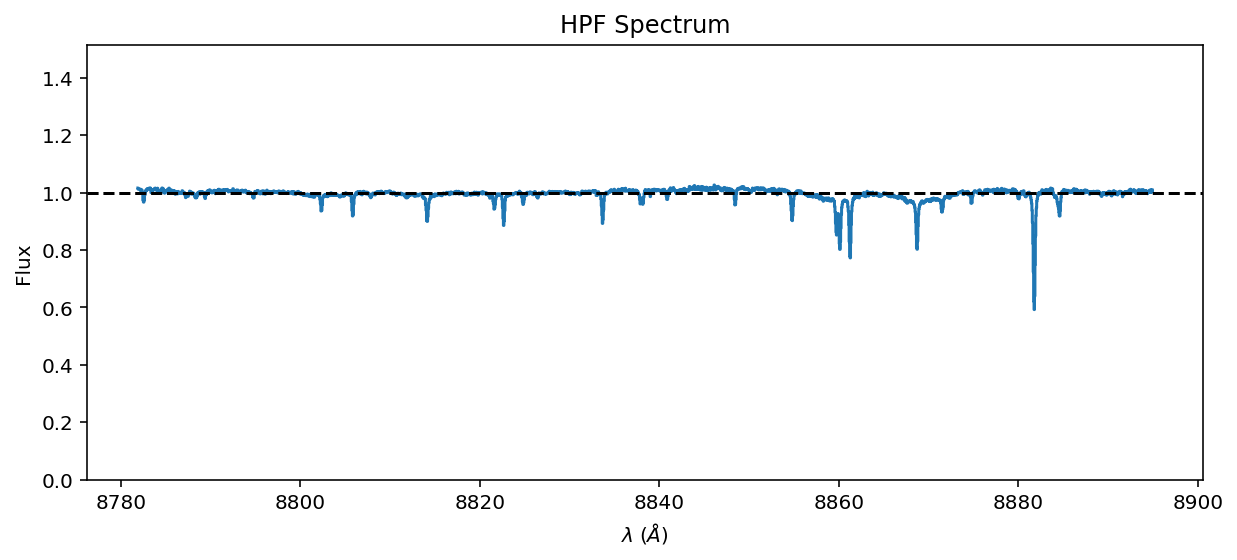

In [23]:
ax=flattened_telluric.plot(ylo=0)
ax.axhline(1.0, color='k', linestyle='dashed');

Hooray! We have flattened the continuum! :)  In practice this process takes some more fine-tuning of the model complexity, etc, and one may prefer a strategy of iteratively fitting and masking.  Ideally we would use the GP smoothing technique, which is possible.